In [1]:
%cd ../..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/jeffrey-uso9-03-dev-ci01/code/Users/jeffrey.tackes/ModernTS_2E


In [2]:
import os
import shutil
import json

import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path

from tqdm.autonotebook import tqdm
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

from statsforecast import StatsForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import Autoformer
from neuralforecast.auto import AutoAutoformer
from neuralforecast.losses.pytorch import MQLoss
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mse, mase
from functools import partial

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

/tmp/ipykernel_179559/2810173236.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-08-15 23:50:19,739	WARNING __init__.py:21 -- Package pickle5 becomes unnecessary in Python 3.8 and above. Its presence may confuse libraries including Ray. Please uninstall the package.
/anaconda/envs/demand_planning/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
TRAIN_SUBSAMPLE = True  # Trains a subsample of IDs to improve run speed
RETUNE = True  # if false, will use pre-trained hyperparameters when generating the AUTO NeuralForecast

In [4]:
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")
try:
    #Reading the missing value imputed and train test split data
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
    # Read in the Validation dataset as test_df so that we predict on it
    test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
    # test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed_feature_engg.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Feature Engineering.ipynb in Chapter06
    </div>
    """))

In [5]:
train_df.head(2)

,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,timestamp_Minute_sin_1,timestamp_Minute_sin_2,timestamp_Minute_sin_3,timestamp_Minute_sin_4,timestamp_Minute_sin_5,timestamp_Minute_cos_1,timestamp_Minute_cos_2,timestamp_Minute_cos_3,timestamp_Minute_cos_4,timestamp_Minute_cos_5
0,2012-01-01 00:00:00,MAC000061,0.114,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0
1,2012-01-01 00:30:00,MAC000061,0.113,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,5.665539e-16,-1.133108e-15,2.143751e-15,-2.266215e-15,6.123234e-16,-1.0,1.0,-1.0,1.0,-1.0


In [6]:
print("Total # of IDs Pre-Sampling: ", len(train_df.LCLid.unique()))

Total # of IDs Pre-Sampling:  150


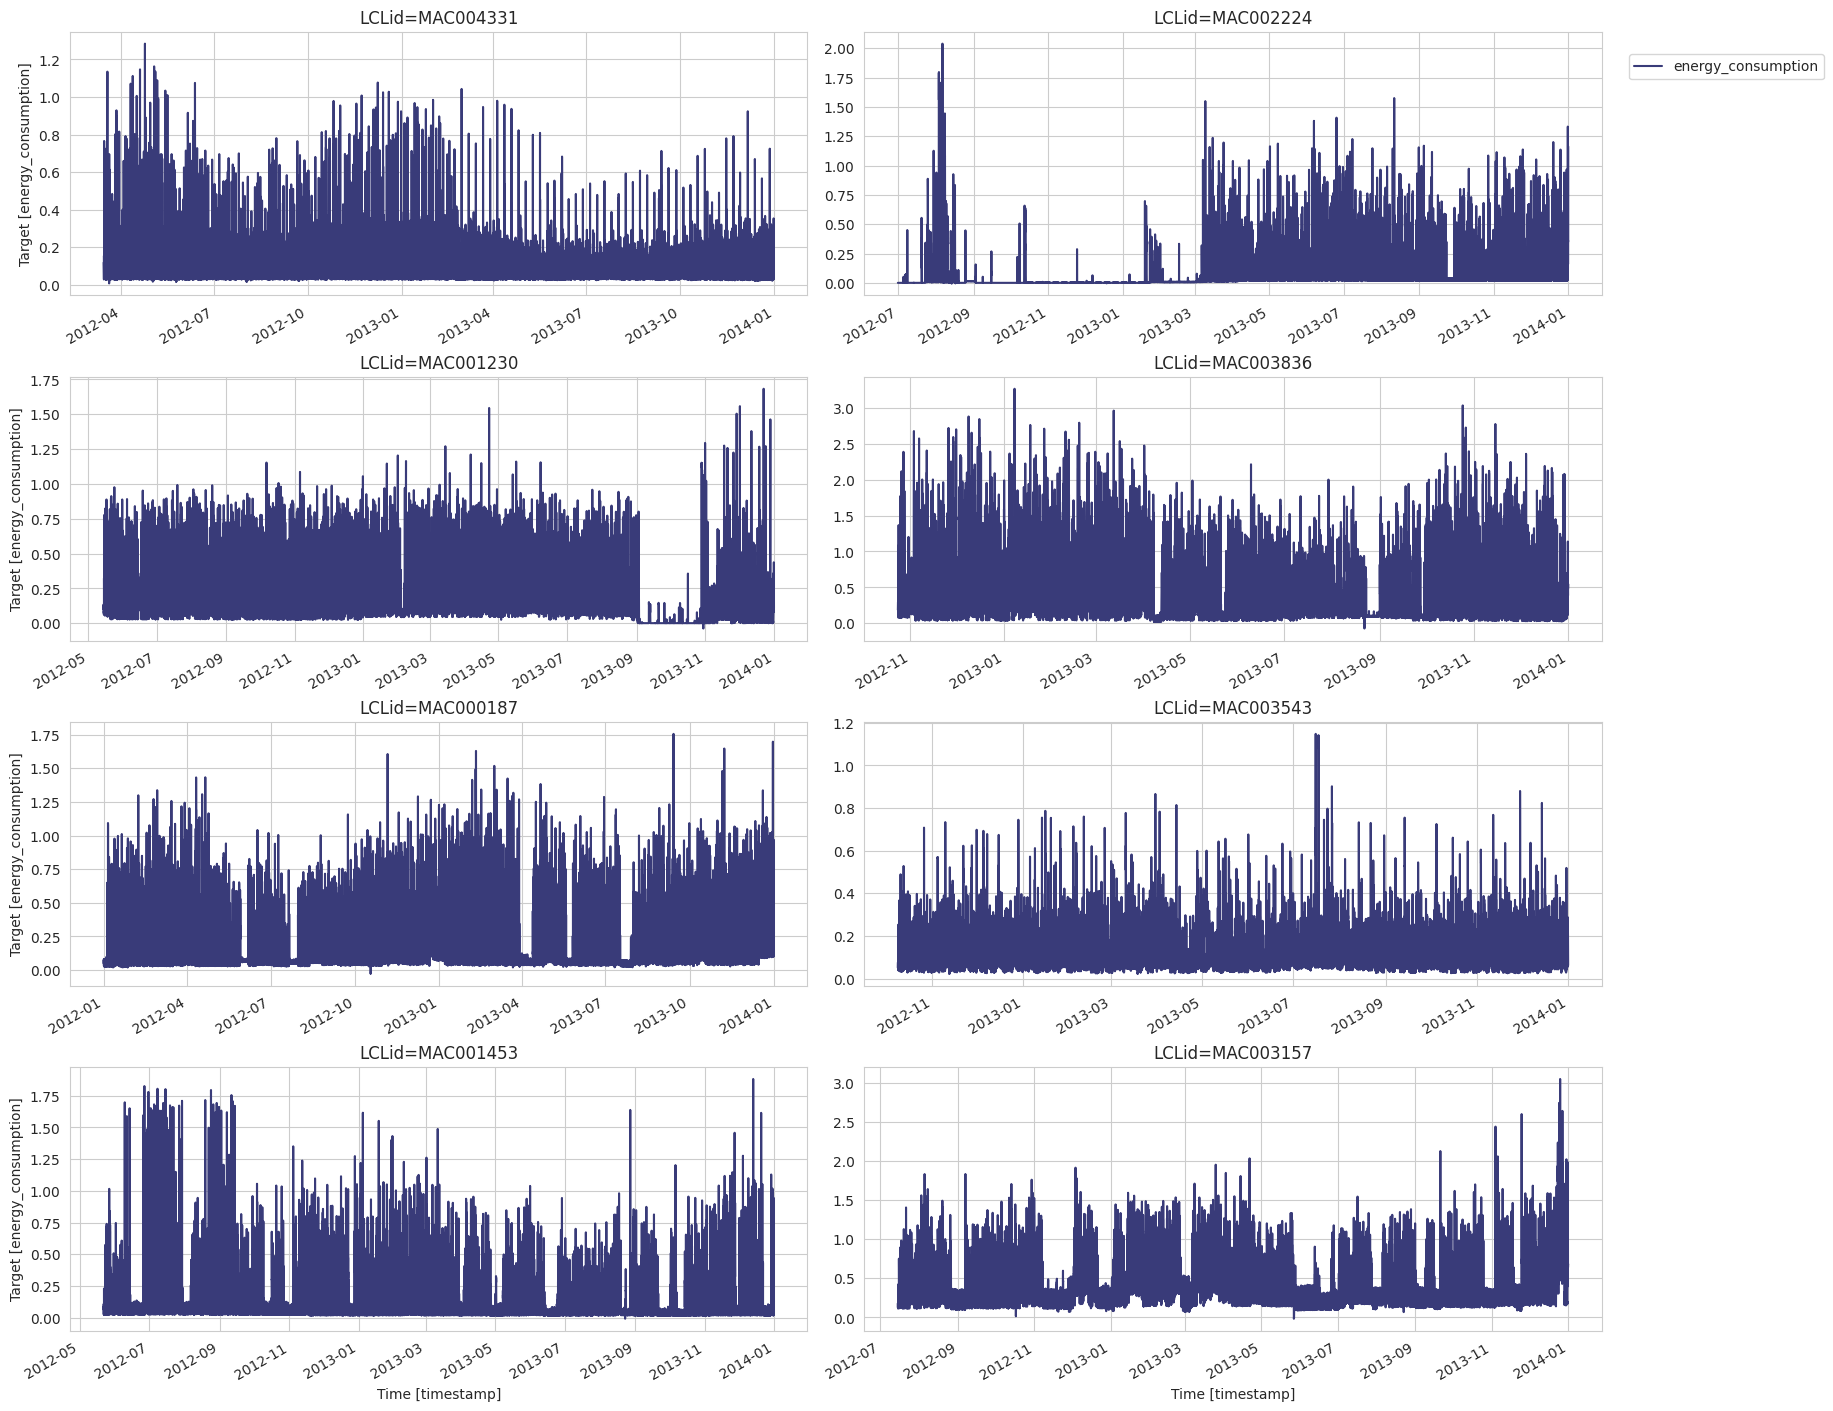

In [7]:
StatsForecast.plot(train_df, engine='matplotlib', id_col='LCLid',time_col= 'timestamp', target_col='energy_consumption')

In [8]:
# To run on smaller set of data for daster iteration.
if TRAIN_SUBSAMPLE:
    print("sub sampling")
    SAMPLE = 10
    sampled_LCLids = pd.Series(train_df.LCLid.unique().remove_unused_categories().categories).sample(SAMPLE, random_state=99).tolist()
    train_df = train_df.loc[train_df.LCLid.isin(sampled_LCLids)]
    test_df = test_df.loc[test_df.LCLid.isin(sampled_LCLids)]

sub sampling


In [9]:
print("Total # of IDs Post Sampling: ", len(train_df.LCLid.unique()))

Total # of IDs Post Sampling:  10


## Train, Validation, Test Set

In [10]:
print("Training Min Date: ", train_df.timestamp.min(), 
      "\nTraining Max Date: ", train_df.timestamp.max(), 
      "\nTesting Min Date: ", test_df.timestamp.min(),
      "\nTesting Max Date: ", test_df.timestamp.max()
)

Training Min Date:  2012-01-01 00:00:00 
Training Max Date:  2013-12-31 23:30:00 
Testing Min Date:  2014-01-01 00:00:00 
Testing Max Date:  2014-01-31 23:30:00


In [11]:
#Keeping 1 days aside as a validation set
cutoff = train_df.timestamp.max() - pd.Timedelta(1, "D")

validation_df = train_df[(train_df.timestamp>cutoff)].reset_index(drop=True) # validation prediction set
training_df = train_df[(train_df.timestamp<=cutoff)].reset_index(drop=True) # training set used for validation set

print(f"Train Max: {training_df.timestamp.max()} \nValidation Min: {validation_df.timestamp.min()} \nValidation Max: {validation_df.timestamp.max()}")
print(f"Validation Horizon: {len(validation_df.timestamp.unique())}")


Train Max: 2013-12-30 23:30:00 
Validation Min: 2013-12-31 00:00:00 
Validation Max: 2013-12-31 23:30:00
Validation Horizon: 48


##### Define Validation model parameters

In [23]:
h = 48
max_steps = 50

## Training Autoformer Model

In [13]:
model_untuned = [Autoformer(h=h,  input_size = 48*7,              
                max_steps=max_steps)]

model_untuned = NeuralForecast(models=model_untuned, freq='30min')
model_untuned.fit(training_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption')

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MAE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | decomp        | SeriesDecomp  | 0     
4 | enc_embedding | DataEmbedding | 384   
5 | dec_embedding | DataEmbedding | 384   
6 | encoder       | Encoder       | 148 K 
7 | decoder       | Decoder       | 141 K 
------------------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.


In [14]:
# Get Predictions for validation
pred_df =  model_untuned.predict(futr_df=validation_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df = pred_df.merge(validation_df[['LCLid','timestamp','energy_consumption']], on=['LCLid','timestamp'], how='left')
pred_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,LCLid,timestamp,Autoformer,energy_consumption
0,MAC000126,2013-12-31 00:00:00,0.057066,0.093
1,MAC000126,2013-12-31 00:30:00,0.106815,0.109
2,MAC000126,2013-12-31 01:00:00,0.120745,0.082
3,MAC000126,2013-12-31 01:30:00,0.074723,0.067
4,MAC000126,2013-12-31 02:00:00,0.099481,0.043


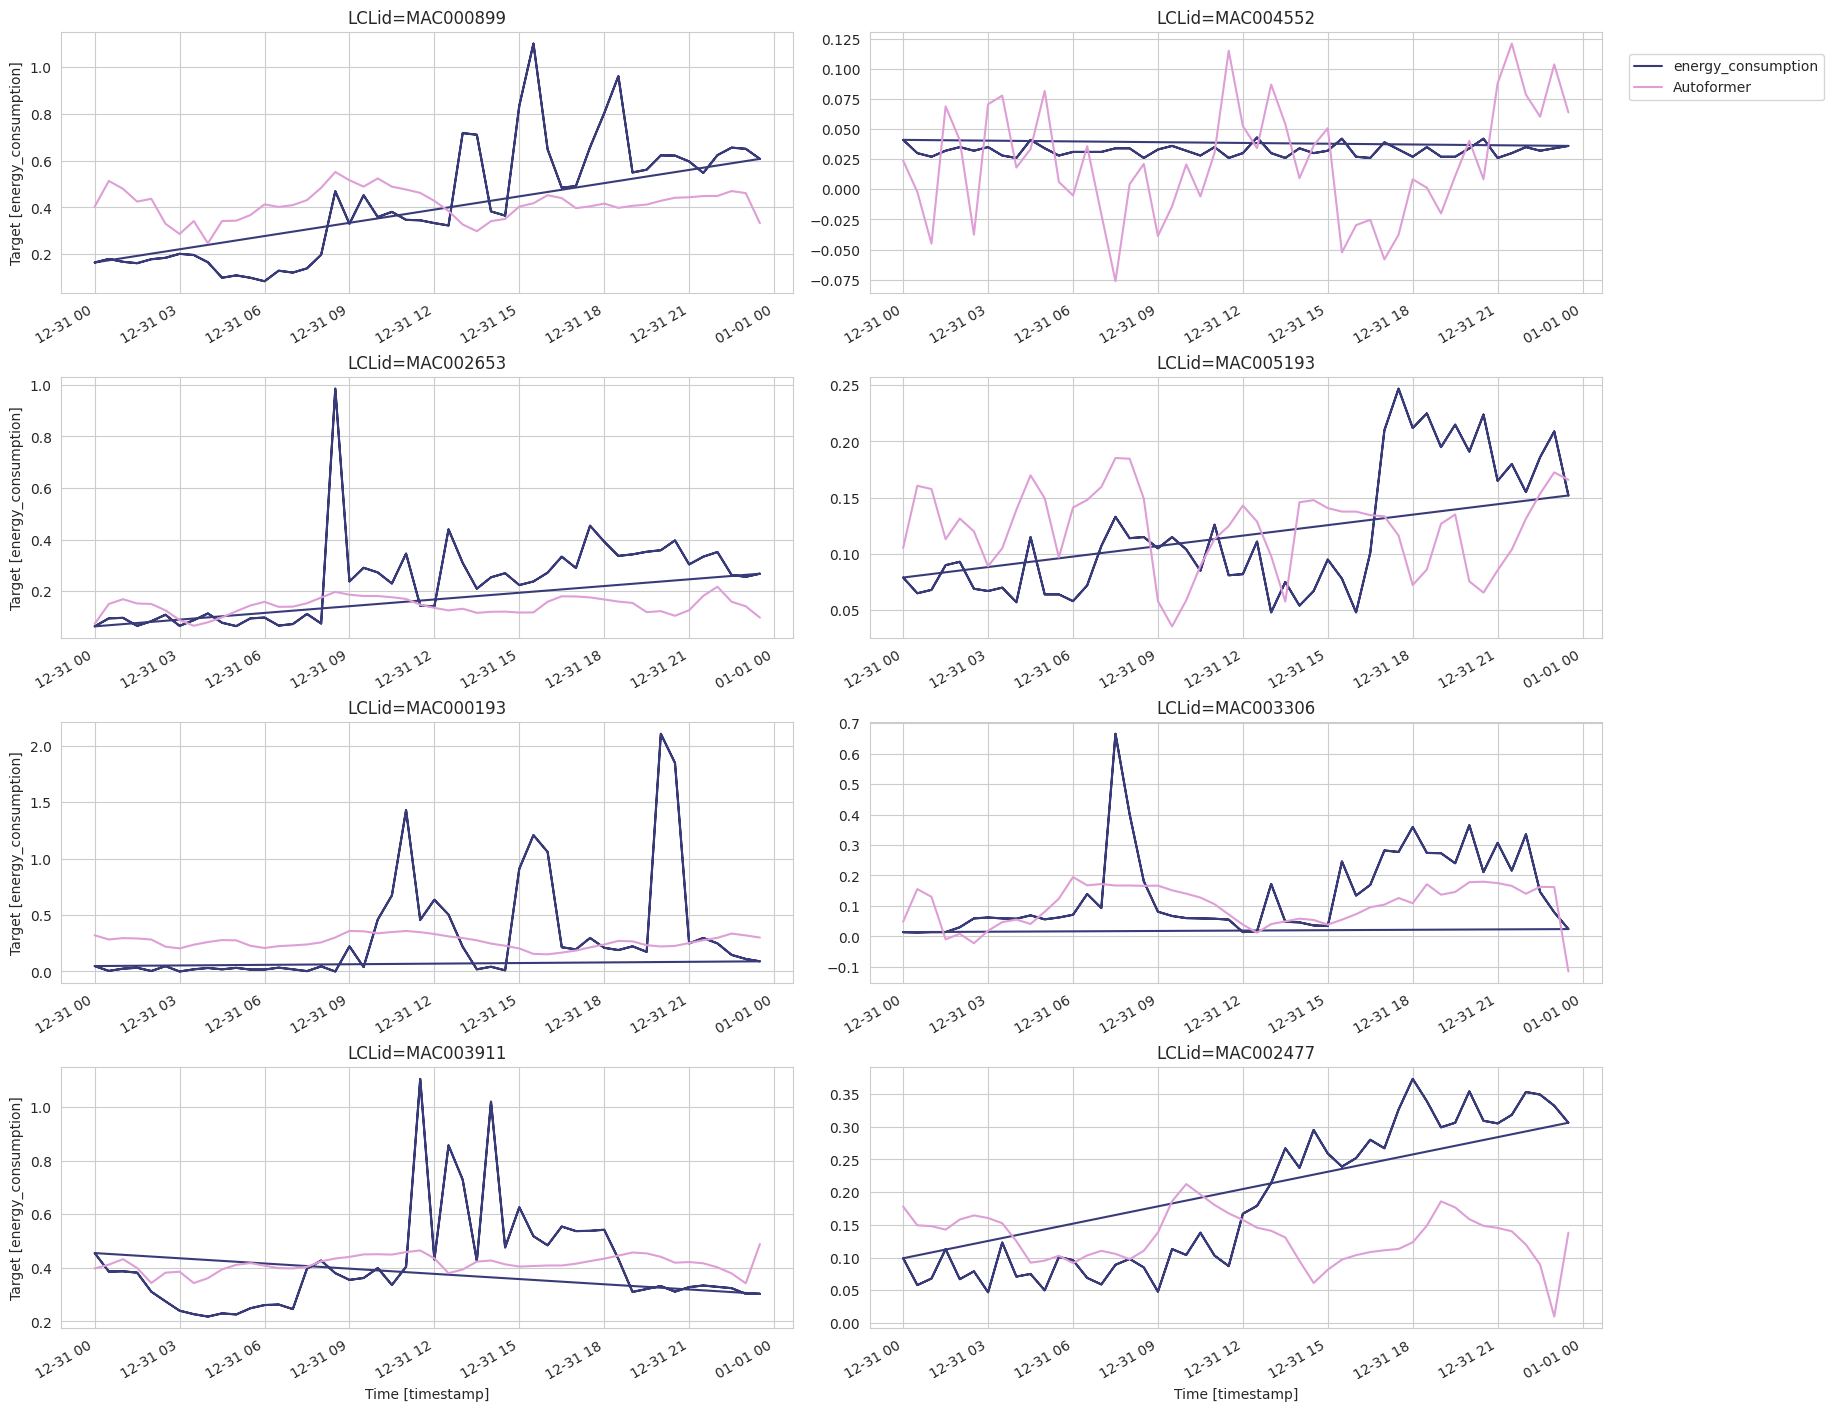

In [15]:
#visualize results
StatsForecast.plot(validation_df[['LCLid','timestamp','energy_consumption']], 
                   pred_df, engine='matplotlib', 
                   id_col='LCLid',
                   time_col= 'timestamp', 
                   target_col='energy_consumption',
                   models=['Autoformer'])

#### Evaluate Autoformer forecast

In [16]:
fcst_mase = partial(mase, seasonality=48)

# Get metrics for individual LCLid's
Autoformer_metrics = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

# Get aggregated metrics for across all LCLid's by model
Autoformer_metrics_agg = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [17]:
Autoformer_metrics_agg

,metric,Autoformer
0,rmse,0.164175
1,mae,0.119901
2,mse,0.042233
3,mase,1.075639


## Autoformer Tuned
Since hyperparameters are key to performance in Neural Networks, NIXTLA has made this search each through the incorporation of Auto forecast.
Each NeuralForecast model has an AUTO class which allow you to easily tune your hyperparameters.

Auto Forecast can time, you can load the pre-trained hyperparameters or choose to retune on your own.
Set ```RETUNE = True``` if you wish to retune.


In [18]:
# Define the file path
config_file_path = 'notebooks/Chapter16/saved_params_config/Autoformer_best_config.json'
try:
    with open(config_file_path, 'r') as config_file:
        loaded_config = json.load(config_file)
        print(loaded_config)
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. 
    </div>
    """))
    

In [25]:
Autoformer_config = {
    "max_steps": max_steps,  # This parameter can be adjusted if needed
    "input_size": tune.choice([h,h*7,h*7*2]), # Size of input window
    "learning_rate": tune.loguniform(1e-2, 1e-1),  # Initial learning rate
    "scaler_type": tune.choice(["minmax", "standard"]),
    "batch_size": tune.choice([32, 64]),
    "valid_batch_size": 16,
    #"early_stop_patience_steps": 3,
    "hidden_size": 64,
    #"windows_batch_size": 128,
    "random_seed": 10,
    #"n_head":tune.choice([64, 128])

}

if RETUNE == True:
    models = [AutoAutoformer(h=h, 
                     config = Autoformer_config,
                     search_alg = HyperOptSearch(),
                     backend = 'ray',
                     num_samples = 20,
                     cpus=10
                     )]

else:
    models = [AutoAutoformer(h=h, 
                    config = loaded_config,
                    search_alg = None,
                    backend = 'ray',
                    #cpus=1
                    )]


model_tuned = NeuralForecast(models=models, freq='30min')
model_tuned.fit(training_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption',  val_size = 48)

(_train_tune pid=339634) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=339634) Seed set to 10
(_train_tune pid=339634) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=339634)   warnings.warn(
(_train_tune pid=339634) GPU available: False, used: False
(_train_tune pid=339634) TPU available: False, using: 0 TPU cores
(_train_tune pid=339634) IPU available: False, using: 0 IPUs
(_train_tune pid=339634) HPU available: False, using: 0 HPUs
(_train_tune pid=339634) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_9d3c825c_1_batch_size=32,h=48,hidden_siz

Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]


(_train_tune pid=339838) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead. [repeated 2x across cluster]
(_train_tune pid=339838) Seed set to 10 [repeated 2x across cluster]
(_train_tune pid=339838) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps. [repeated 2x across cluster]
(_train_tune pid=339838)   warnings.warn( [repeated 2x across cluster]
(_train_tune pid=339725) GPU available: False, used: False
(_train_tune pid=339725) TPU available: False, using: 0 TPU cores
(_train_tune pid=339725) IPU available: False, using: 0 IPUs
(_train_tune pid=339725) HPU available: False, using: 0 HPUs
(_train_tune pid=339725) Missing logger fold

Epoch 3:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.050, train_loss_epoch=1.050]


(_train_tune pid=339971) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=339971) Seed set to 10
(_train_tune pid=339971) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=339971)   warnings.warn(
(_train_tune pid=339838) ------------------------------------------------ [repeated 2x across cluster]


Epoch 5:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.240, train_loss_epoch=1.240]


(_train_tune pid=339971) GPU available: False, used: False
(_train_tune pid=339971) TPU available: False, using: 0 TPU cores
(_train_tune pid=339971) IPU available: False, using: 0 IPUs
(_train_tune pid=339971) HPU available: False, using: 0 HPUs
(_train_tune pid=339971) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_fcf9ab50_4_batch_size=64,h=48,hidden_size=64,input_size=336,learning_rate=0.0192,loss=ref_ph_de895953,max_steps=50,ran_2024-08-16_12-51-15/lightning_logs
(_train_tune pid=339971) 
(_train_tune pid=339971)   | Name          | Type          | Params
(_train_tune pid=339971) 0 | loss          | MAE           | 0     
(_train_tune pid=339971) 1 | padder_train  | ConstantPad1d | 0     
(_train_tune pid=339971) 2 | scaler        | TemporalNorm  | 0     
(_train_tune pid=339971) 3 | decomp        | SeriesDecomp  | 0     
(_train_tune pid=339971) 4 | enc_embedding | DataEmbedding | 192   
(_train_tune pid=339971) 5 | dec_embedding | 

Epoch 10:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.726, train_loss_epoch=0.726]


(_train_tune pid=340116) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=340116) Seed set to 10
(_train_tune pid=340116) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=340116)   warnings.warn(


Epoch 11:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.691, train_loss_epoch=0.691]


(_train_tune pid=340116) GPU available: False, used: False
(_train_tune pid=340116) TPU available: False, using: 0 TPU cores
(_train_tune pid=340116) IPU available: False, using: 0 IPUs
(_train_tune pid=340116) HPU available: False, using: 0 HPUs
(_train_tune pid=339971) ------------------------------------------------ [repeated 2x across cluster]
(_train_tune pid=340116) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_7254ad8b_5_batch_size=32,h=48,hidden_size=64,input_size=672,learning_rate=0.0223,loss=ref_ph_de895953,max_steps=50,ran_2024-08-16_12-51-20/lightning_logs
(_train_tune pid=340116) 
(_train_tune pid=340116)   | Name          | Type          | Params
(_train_tune pid=340116) 0 | loss          | MAE           | 0     
(_train_tune pid=340116) 1 | padder_train  | ConstantPad1d | 0     
(_train_tune pid=340116) 2 | scaler        | TemporalNorm  | 0     
(_train_tune pid=340116) 3 | decomp        | SeriesDecomp  | 0     
(_train_tu

Epoch 16:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.515, train_loss_epoch=0.515] 

(_train_tune pid=340246) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=340246) Seed set to 10
(_train_tune pid=340246) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=340246)   warnings.warn(
(_train_tune pid=340116) ------------------------------------------------ [repeated 2x across cluster]
(_train_tune pid=340246) GPU available: False, used: False
(_train_tune pid=340246) TPU available: False, using: 0 TPU cores
(_train_tune pid=340246) IPU available: False, using: 0 IPUs
(_train_tune pid=340246) HPU available: False, using: 0 HPUs
(_train_tune pid=340246) Missing logger folder: /home/azu

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=340404) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=340404) Seed set to 10
(_train_tune pid=340404) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=340404)   warnings.warn(
(_train_tune pid=340246) ------------------------------------------------ [repeated 2x across cluster]
(_train_tune pid=340404) GPU available: False, used: False
(_train_tune pid=340404) TPU available: False, using: 0 TPU cores
(_train_tune pid=340404) IPU available: False, using: 0 IPUs
(_train_tune pid=340404) HPU available: False, using: 0 HPUs
(_train_tune pid=340404) Missing logger folder: /home/azu

Epoch 26:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.313, train_loss_epoch=0.313] 

(_train_tune pid=340562) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=340562) Seed set to 10
(_train_tune pid=340562) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=340562)   warnings.warn(
(_train_tune pid=340404) ------------------------------------------------ [repeated 2x across cluster]
(_train_tune pid=340562) GPU available: False, used: False
(_train_tune pid=340562) TPU available: False, using: 0 TPU cores
(_train_tune pid=340562) IPU available: False, using: 0 IPUs
(_train_tune pid=340562) HPU available: False, using: 0 HPUs


Epoch 2:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=3.040, train_loss_epoch=3.040] 

(_train_tune pid=340562) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_8db9667e_8_batch_size=64,h=48,hidden_size=64,input_size=672,learning_rate=0.0464,loss=ref_ph_de895953,max_steps=50,ran_2024-08-16_12-51-37/lightning_logs
(_train_tune pid=340562) 
(_train_tune pid=340562)   | Name          | Type          | Params
(_train_tune pid=340562) 0 | loss          | MAE           | 0     
(_train_tune pid=340562) 1 | padder_train  | ConstantPad1d | 0     
(_train_tune pid=340562) 2 | scaler        | TemporalNorm  | 0     
(_train_tune pid=340562) 3 | decomp        | SeriesDecomp  | 0     
(_train_tune pid=340562) 4 | enc_embedding | DataEmbedding | 192   
(_train_tune pid=340562) 5 | dec_embedding | DataEmbedding | 192   
(_train_tune pid=340562) 6 | encoder       | Encoder       | 41.6 K
(_train_tune pid=340562) 7 | decoder       | Decoder       | 37.8 K
(_train_tune pid=340562) 79.7 K    Trainable params
(_train_tune pid=340562) 0         N

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=340732) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=340732) Seed set to 10
(_train_tune pid=340732) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=340732)   warnings.warn(
(_train_tune pid=340562) ------------------------------------------------ [repeated 2x across cluster]
(_train_tune pid=340732) GPU available: False, used: False
(_train_tune pid=340732) TPU available: False, using: 0 TPU cores
(_train_tune pid=340732) IPU available: False, using: 0 IPUs
(_train_tune pid=340732) HPU available: False, using: 0 HPUs
(_train_tune pid=340732) Missing logger folder: /home/azu

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.41it/s, v_num=0, train_loss_step=0.307, train_loss_epoch=0.202]


2024-08-16 12:52:38,884	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=339634) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=340732) ------------------------------------------------ [repeated 2x across cluster]


(_train_tune pid=339634) 
Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.38it/s, v_num=0, train_loss_step=0.307, train_loss_epoch

(_train_tune pid=339634) Seed set to 10
(_train_tune pid=339634) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=339634)   warnings.warn(
(_train_tune pid=339634) GPU available: False, used: False
(_train_tune pid=339634) TPU available: False, using: 0 TPU cores
(_train_tune pid=339634) IPU available: False, using: 0 IPUs
(_train_tune pid=339634) HPU available: False, using: 0 HPUs
(_train_tune pid=339634) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_6d8e0f7f_10_batch_size=32,h=48,hidden_size=64,input_size=336,learning_rate=0.0145,loss=ref_ph_de895953,max_steps=50,ra_2024-08-16_12-51-55/lightning_logs
(_train_tune pid=339634) 
(_train_tune pid=339634)   | Name          | Type          | Params
(_train_tune pid=339634) 0 | loss          | MAE           | 0     
(_train_tune p

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-16 12:53:57,746	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=340246) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=339634) ------------------------------------------------ [repeated 2x across cluster]


(_train_tune pid=340246) 
Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  0.25it/s, v_num=0, train_loss_step=3.990, train_loss_epoch

(_train_tune pid=340246) Seed set to 10
(_train_tune pid=340246) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=340246)   warnings.warn(
(_train_tune pid=340246) GPU available: False, used: False
(_train_tune pid=340246) TPU available: False, using: 0 TPU cores
(_train_tune pid=340246) IPU available: False, using: 0 IPUs
(_train_tune pid=340246) HPU available: False, using: 0 HPUs
(_train_tune pid=340246) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_346ce250_11_batch_size=32,h=48,hidden_size=64,input_size=48,learning_rate=0.0223,loss=ref_ph_de895953,max_steps=50,ran_2024-08-16_12-52-39/lightning_logs
(_train_tune pid=340246) 
(_train_tune pid=340246)   | Name          | Type          | Params
(_train_tune pid=340246) 0 | loss          | MAE           | 0     
(_train_tune p

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=0, train_loss_step=0.300, train_loss_epoch=0.196]


2024-08-16 12:55:41,019	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=340404) 
Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  0.19it/s, v_num=0, train_loss_step=0.300, train_loss_epoch

(_train_tune pid=340404) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=340246) ------------------------------------------------ [repeated 2x across cluster]
(_train_tune pid=340404) Seed set to 10
(_train_tune pid=340404) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=340404)   warnings.warn(
(_train_tune pid=340404) GPU available: False, used: False
(_train_tune pid=340404) TPU available: False, using: 0 TPU cores
(_train_tune pid=340404) IPU available: False, using: 0 IPUs
(_train_tune pid=340404) HPU available: False, using: 0 HPUs
(_train_tune pid=340404) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_88822e70_12_batch_size=64,h=48,hidden_size=64,input_size=336,learning_rate=0.0900,loss=ref_ph_de895953,max_steps=50,ra_2024-08-16_12-53-57/lightning_logs
(

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-16 12:56:22,757	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 [repeated 3x across cluster]


(_train_tune pid=340246) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=340404) ------------------------------------------------ [repeated 2x across cluster]


(_train_tune pid=340246) 
Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  0.33it/s, v_num=0, train_loss_step=0.306, train_loss_epoch

(_train_tune pid=340246) Seed set to 10
(_train_tune pid=340246) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=340246)   warnings.warn(
(_train_tune pid=340246) GPU available: False, used: False
(_train_tune pid=340246) TPU available: False, using: 0 TPU cores
(_train_tune pid=340246) IPU available: False, using: 0 IPUs
(_train_tune pid=340246) HPU available: False, using: 0 HPUs
(_train_tune pid=340246) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_5f4ae305_13_batch_size=32,h=48,hidden_size=64,input_size=672,learning_rate=0.0372,loss=ref_ph_de895953,max_steps=50,ra_2024-08-16_12-55-41/lightning_logs
(_train_tune pid=340246) 
(_train_tune pid=340246)   | Name          | Type          | Params
(_train_tune pid=340246) 0 | loss          | MAE           | 0     
(_train_tune p

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-16 13:08:24,710	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=339971) 
Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00,  0.05it/s, v_num=0, train_loss_step=0.122, train_loss_epoch

(_train_tune pid=339971) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=340246) ------------------------------------------------ [repeated 2x across cluster]
(_train_tune pid=339971) Seed set to 10
(_train_tune pid=339971) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=339971)   warnings.warn(
(_train_tune pid=339971) GPU available: False, used: False
(_train_tune pid=339971) TPU available: False, using: 0 TPU cores
(_train_tune pid=339971) IPU available: False, using: 0 IPUs
(_train_tune pid=339971) HPU available: False, using: 0 HPUs
(_train_tune pid=339971) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_0f974a2c_14_batch_size=64,h=48,hidden_size=64,input_size=48,learning_rate=0.0111,loss=ref_ph_de895953,max_steps=50,ran_2024-08-16_12-56-22/lightning_logs
(

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00,  0.04it/s, v_num=0, train_loss_step=1.590, train_loss_epoch=3.100]


2024-08-16 13:10:00,450	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=339725) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=339971) ------------------------------------------------ [repeated 2x across cluster]


(_train_tune pid=339725) 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1

(_train_tune pid=339725) Seed set to 10
(_train_tune pid=339725) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=339725)   warnings.warn(
(_train_tune pid=339725) GPU available: False, used: False
(_train_tune pid=339725) TPU available: False, using: 0 TPU cores
(_train_tune pid=339725) IPU available: False, using: 0 IPUs
(_train_tune pid=339725) HPU available: False, using: 0 HPUs
(_train_tune pid=339725) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_27254b28_15_batch_size=32,h=48,hidden_size=64,input_size=48,learning_rate=0.0836,loss=ref_ph_de895953,max_steps=50,ran_2024-08-16_13-08-24/lightning_logs
(_train_tune pid=339725) 
(_train_tune pid=339725)   | Name          | Type          | Params
(_train_tune pid=339725) 0 | loss          | MAE           | 0     
(_train_tune p

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-16 13:10:32,711	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.08it/s]


(_train_tune pid=339971) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=339725) ------------------------------------------------ [repeated 2x across cluster]
(_train_tune pid=339971) Seed set to 10
(_train_tune pid=339971) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=339971)   warnings.warn(
(_train_tune pid=339971) GPU available: False, used: False
(_train_tune pid=339971) TPU available: False, using: 0 TPU cores
(_train_tune pid=339971) IPU available: False, using: 0 IPUs
(_train_tune pid=339971) HPU available: False, using: 0 HPUs
(_train_tune pid=339971) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_cf8f5d47_16_batch_size=32,h=48,hidden_size=64,input_size=48,learning_rate=0.0124,loss=ref_ph_de895953,max_steps=50,ran_2024-08-16_13-10-00/lightning_logs
(

Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]


2024-08-16 13:10:34,093	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00,  0.05it/s, v_num=0, train_loss_step=0.738, train_loss_epoch=0.738, valid_loss=0.118]


2024-08-16 13:12:21,827	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=339725) `Trainer.fit` stopped: `max_steps=50` reached. [repeated 2x across cluster]
(_train_tune pid=339634) ------------------------------------------------ [repeated 4x across cluster]
(_train_tune pid=339634) Seed set to 10
(_train_tune pid=339634) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=339634)   warnings.warn(
(_train_tune pid=339634) GPU available: False, used: False
(_train_tune pid=339634) TPU available: False, using: 0 TPU cores
(_train_tune pid=339634) IPU available: False, using: 0 IPUs
(_train_tune pid=339634) HPU available: False, using: 0 HPUs
(_train_tune pid=339634) Missing logger folder

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.38it/s, v_num=0, train_loss_step=2.880, train_loss_epoch=2.710]


(_train_tune pid=339725) Seed set to 10
(_train_tune pid=339725) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=339725)   warnings.warn(
(_train_tune pid=339725) GPU available: False, used: False
(_train_tune pid=339725) TPU available: False, using: 0 TPU cores
(_train_tune pid=339725) IPU available: False, using: 0 IPUs
(_train_tune pid=339725) HPU available: False, using: 0 HPUs
(_train_tune pid=339725) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_00ac6eff_18_batch_size=32,h=48,hidden_size=64,input_size=336,learning_rate=0.0170,loss=ref_ph_de895953,max_steps=50,ra_2024-08-16_13-10-34/lightning_logs
(_train_tune pid=339725) 
(_train_tune pid=339725)   | Name          | Type          | Params
(_train_tune pid=339725) 0 | loss          | MAE           | 0     
(_train_tune p

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.43it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=0.871]


2024-08-16 13:12:40,886	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=339971) 
Epoch 48:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=12.00

(_train_tune pid=339971) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=339725) ------------------------------------------------ [repeated 2x across cluster]
(_train_tune pid=339971) Seed set to 10
(_train_tune pid=339971) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=339971)   warnings.warn(


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]


(_train_tune pid=339971) GPU available: False, used: False
(_train_tune pid=339971) TPU available: False, using: 0 TPU cores
(_train_tune pid=339971) IPU available: False, using: 0 IPUs
(_train_tune pid=339971) HPU available: False, using: 0 HPUs
(_train_tune pid=339971) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_b480c9ba_19_batch_size=64,h=48,hidden_size=64,input_size=48,learning_rate=0.0228,loss=ref_ph_de895953,max_steps=50,ran_2024-08-16_13-12-21/lightning_logs
(_train_tune pid=339971) 
(_train_tune pid=339971)   | Name          | Type          | Params
(_train_tune pid=339971) 0 | loss          | MAE           | 0     
(_train_tune pid=339971) 1 | padder_train  | ConstantPad1d | 0     
(_train_tune pid=339971) 2 | scaler        | TemporalNorm  | 0     
(_train_tune pid=339971) 3 | decomp        | SeriesDecomp  | 0     
(_train_tune pid=339971) 4 | enc_embedding | DataEmbedding | 192   
(_train_tune pid=339971) 5 | dec_embedding | 

Epoch 49:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=12.90, train_loss_epoch=12.90]


2024-08-16 13:12:43,842	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=339634) `Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.42it/s, v_num=0, train_loss_step=14.20, train_loss_epoch=12.90]


2024-08-16 13:14:50,103	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=339971) 
Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.39it/s, v_num=0, train_loss_step=1.290, train_loss_epoch

(_train_tune pid=339634) ------------------------------------------------ [repeated 4x across cluster]
(_train_tune pid=339634) Seed set to 10
(_train_tune pid=339634) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=339634)   warnings.warn(
(_train_tune pid=339634) GPU available: False, used: False
(_train_tune pid=339634) TPU available: False, using: 0 TPU cores
(_train_tune pid=339634) IPU available: False, using: 0 IPUs
(_train_tune pid=339634) HPU available: False, using: 0 HPUs
(_train_tune pid=339634) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_12-51-03/_train_tune_9c804ac9_20_batch_size=64,h=48,hidden_size=64,input_size=48,learning_rate=0.0451,loss=ref_ph_de895953,max_steps=50,ran_2024-08-16_13-12-40/lightning_logs
(_train_tune pid=339634) 
(_train_tune pid=339634)   | Name          | Ty

Epoch 31:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.150, train_loss_epoch=1.150] 

(_train_tune pid=339634) `Trainer.fit` stopped: `max_steps=50` reached.2024-08-16 13:14:53,697	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.37it/s, v_num=0, train_loss_step=1.540, train_loss_epoch=1.160]


2024-08-16 13:16:01,099	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


 
Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00,  0.06it/s, v_num=0, train_loss_step=0.728, train_loss_epoch=0.728, valid_loss=0.115

(_train_tune pid=340732) `Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00,  0.07it/s, v_num=0, train_loss_step=11.40, train_loss_epoch=11.10]


2024-08-16 13:17:04,912	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=340404) 
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1

(_train_tune pid=340404) `Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00,  0.04it/s, v_num=0, train_loss_step=0.494, train_loss_epoch=0.517]


2024-08-16 13:23:19,718	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=339838) `Trainer.fit` stopped: `max_steps=50` reached.


(_train_tune pid=339838) 
Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00,  0.04it/s, v_num=0, train_loss_step=0.648

2024-08-16 13:23:31,561	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=340116) `Trainer.fit` stopped: `max_steps=50` reached.


(_train_tune pid=340116) 
Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  0.14it/s, v_num=0, train_loss_step=0.746

2024-08-16 13:24:07,960	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 48:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.514, train_loss_epoch=0.514]


(_train_tune pid=339725) `Trainer.fit` stopped: `max_steps=50` reached.


(_train_tune pid=339725) 
Epoch 42:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.863

2024-08-16 13:24:28,550	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=340562) `Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00,  0.09it/s, v_num=0, train_loss_step=0.377, train_loss_epoch=0.467]


2024-08-16 13:25:29,668	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
Seed set to 10
/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
(_train_tune pid=340246) `Trainer.fit` stopped: `max_steps=50` reached.


(_train_tune pid=340246) 
Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  0.12it/s, v_num=0, train_loss_step=0.326, train_loss_epoch

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MAE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | decomp        | SeriesDecomp  | 0     
4 | enc_embedding | DataEmbedding | 192   
5 | dec_embedding | DataEmbedding | 192   
6 | encoder       | Encoder       | 41.6 K
7 | decoder       | Decoder       | 37.8 K
------------------------------------------------
79.7 K    Trainable params
0         Non-trainable params
79.7 K    Total params
0.319     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=50` reached.


The results of the tuning can then be viewed by running the below.

In [26]:
Autoformer_best_config = model_tuned.models[0].results.get_best_result().config

# Remove specific keys using the pop method and then saving so we can extract parameters later
Autoformer_best_config.pop("loss", None)
Autoformer_best_config.pop("valid_loss", None)
Autoformer_best_config.pop("h", None)

# Save the filtered configuration to a JSON file
with open(config_file_path, 'w') as config_file:
    json.dump(Autoformer_best_config, config_file, indent=4)

print("Best configuration as string:")
print(Autoformer_best_config)

Best configuration as string:
{'max_steps': 50, 'input_size': 48, 'learning_rate': 0.014581134114227708, 'scaler_type': 'minmax', 'batch_size': 64, 'valid_batch_size': 16, 'hidden_size': 64, 'random_seed': 10}


In [27]:
results = model_tuned.models[0].results.get_dataframe()
results[['loss', 'train_loss', 'timestamp', 
       'training_iteration', 
        'config/max_steps', 'config/input_size',
       'config/learning_rate', 'config/h', 'config/loss',
       ]].head(2)

,loss,train_loss,timestamp,training_iteration,config/max_steps,config/input_size,config/learning_rate,config/h,config/loss
0,0.110770,0.306921,1723812758,1,50,48,0.017731,48,MAE()
1,0.376161,1.592223,1723813800,1,50,336,0.060408,48,MAE()


In [28]:
pred_df_autoAutoformer =  model_tuned.predict(futr_df=validation_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df = pred_df_autoAutoformer.merge(pred_df[['LCLid','timestamp','energy_consumption','Autoformer']], on=['LCLid','timestamp'], how='left')
pred_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,LCLid,timestamp,AutoAutoformer,energy_consumption,Autoformer
0,MAC000126,2013-12-31 00:00:00,0.097388,0.093,0.057066
1,MAC000126,2013-12-31 00:30:00,0.107910,0.109,0.106815
2,MAC000126,2013-12-31 01:00:00,0.084026,0.082,0.120745
3,MAC000126,2013-12-31 01:30:00,0.078051,0.067,0.074723
4,MAC000126,2013-12-31 02:00:00,0.101990,0.043,0.099481


In [29]:
fcst_mase = partial(mase, seasonality=48)

autoAutoformer_metrics = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

autoAutoformer_metrics_agg = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [30]:
autoAutoformer_metrics_agg

,metric,AutoAutoformer,Autoformer
0,rmse,0.159776,0.164175
1,mae,0.114483,0.119901
2,mse,0.042675,0.042233
3,mase,1.036998,1.075639


## TEST SET Predictions

In [31]:
h_test = len(test_df.timestamp.unique()) # horizon of the test set

if RETUNE == True:
    config = Autoformer_best_config
else:
    config = loaded_config

models_test = [AutoAutoformer(h=h_test, 
                    config = config,
                    search_alg = None,
                    backend = 'ray')]

models_test = NeuralForecast(models=models_test, freq='30min')
models_test.fit(train_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption')

(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=351673) Seed set to 10
(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=351673)   warnings.warn(
(_train_tune pid=351673) GPU available: False, used: False
(_train_tune pid=351673) TPU available: False, using: 0 TPU cores
(_train_tune pid=351673) IPU available: False, using: 0 IPUs
(_train_tune pid=351673) HPU available: False, using: 0 HPUs
(_train_tune pid=351673) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_13-50-17/_train_tune_78520_00000_0_2024-08-16_13-50-17/lightn

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.594]


(_train_tune pid=351673) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=351673) Seed set to 10
(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=351673)   warnings.warn(
(_train_tune pid=351673) GPU available: False, used: False
(_train_tune pid=351673) TPU available: False, using: 0 TPU cores
(_train_tune pid=351673) IPU available: False, using: 0 IPUs
(_train_tune pid=351673) HPU available: False, using: 0 HPUs
(_train_tune pid=351673) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_13-50-17/_train_tune_78520_00001_1_2024-08-16_13-50-17/lightning_logs
(_train_tune pid=351673) 
(_train_tune pid=351673)   | Name          | Type          | Params
(_train_tune pid=351673) ------------------------------------------------
(_train_tune pid=351673) 0 | loss        

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.594]


(_train_tune pid=351673) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=351673) Seed set to 10
(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=351673)   warnings.warn(


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]


(_train_tune pid=351673) GPU available: False, used: False
(_train_tune pid=351673) TPU available: False, using: 0 TPU cores
(_train_tune pid=351673) IPU available: False, using: 0 IPUs
(_train_tune pid=351673) HPU available: False, using: 0 HPUs
(_train_tune pid=351673) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_13-50-17/_train_tune_78520_00002_2_2024-08-16_13-50-17/lightning_logs
(_train_tune pid=351673) 
(_train_tune pid=351673)   | Name          | Type          | Params
(_train_tune pid=351673) ------------------------------------------------
(_train_tune pid=351673) 0 | loss          | MAE           | 0     
(_train_tune pid=351673) 1 | padder_train  | ConstantPad1d | 0     
(_train_tune pid=351673) 2 | scaler        | TemporalNorm  | 0     
(_train_tune pid=351673) 3 | decomp        | SeriesDecomp  | 0     
(_train_tune pid=351673) 4 | enc_embedding | DataEmbedding | 192   
(_train_tune pid=351673) 5 | dec_embedding | DataEmbedding | 192   
(_train_

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.594]


(_train_tune pid=351673) `Trainer.fit` stopped: `max_steps=50` reached.


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=351673) Seed set to 10
(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=351673)   warnings.warn(
(_train_tune pid=351673) GPU available: False, used: False
(_train_tune pid=351673) TPU available: False, using: 0 TPU cores
(_train_tune pid=351673) IPU available: False, using: 0 IPUs
(_train_tune pid=351673) HPU available: False, using: 0 HPUs
(_train_tune pid=351673) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_13-50-17/_train_tune_78520_00003_3_2024-08-16_13-50-17/lightning_logs
(_train_tune pid=351673) 
(_train_tune pid=351673)   | Name          | Type          | Params
(_train_tune pid=351673) ------------------------------------------------
(_train_tune pid=351673) 0 | loss          | MAE           | 0     
(_train_tune pid=351673) 1 | padder_train  | 

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.594]


(_train_tune pid=351673) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=351673) Seed set to 10
(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=351673)   warnings.warn(
(_train_tune pid=351673) GPU available: False, used: False
(_train_tune pid=351673) TPU available: False, using: 0 TPU cores
(_train_tune pid=351673) IPU available: False, using: 0 IPUs
(_train_tune pid=351673) HPU available: False, using: 0 HPUs
(_train_tune pid=351673) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_13-50-17/_train_tune_78520_00004_4_2024-08-16_13-50-17/lightning_logs
(_train_tune pid=351673) 
(_train_tune pid=351673)   | Name          | Type          | Params
(_train_tune pid=351673) ------------------------------------------------
(_train_tune pid=351673) 0 | loss        

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.594]


(_train_tune pid=351673) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=351673) Seed set to 10
(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=351673)   warnings.warn(
(_train_tune pid=351673) GPU available: False, used: False
(_train_tune pid=351673) TPU available: False, using: 0 TPU cores
(_train_tune pid=351673) IPU available: False, using: 0 IPUs
(_train_tune pid=351673) HPU available: False, using: 0 HPUs
(_train_tune pid=351673) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_13-50-17/_train_tune_78520_00005_5_2024-08-16_13-50-17/lightning_logs
(_train_tune pid=351673) 
(_train_tune pid=351673)   | Name          | Type          | Params
(_train_tune pid=351673) ------------------------------------------------
(_train_tune pid=351673) 0 | loss        

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.594]


(_train_tune pid=351673) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=351673) Seed set to 10
(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=351673)   warnings.warn(


Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]


(_train_tune pid=351673) GPU available: False, used: False
(_train_tune pid=351673) TPU available: False, using: 0 TPU cores
(_train_tune pid=351673) IPU available: False, using: 0 IPUs
(_train_tune pid=351673) HPU available: False, using: 0 HPUs
(_train_tune pid=351673) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_13-50-17/_train_tune_78520_00006_6_2024-08-16_13-50-17/lightning_logs
(_train_tune pid=351673) 
(_train_tune pid=351673)   | Name          | Type          | Params
(_train_tune pid=351673) ------------------------------------------------
(_train_tune pid=351673) 0 | loss          | MAE           | 0     
(_train_tune pid=351673) 1 | padder_train  | ConstantPad1d | 0     
(_train_tune pid=351673) 2 | scaler        | TemporalNorm  | 0     
(_train_tune pid=351673) 3 | decomp        | SeriesDecomp  | 0     
(_train_tune pid=351673) 4 | enc_embedding | DataEmbedding | 192   
(_train_tune pid=351673) 5 | dec_embedding | DataEmbedding | 192   
(_train_

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.594]


(_train_tune pid=351673) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=351673) Seed set to 10
(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=351673)   warnings.warn(
(_train_tune pid=351673) GPU available: False, used: False
(_train_tune pid=351673) TPU available: False, using: 0 TPU cores
(_train_tune pid=351673) IPU available: False, using: 0 IPUs
(_train_tune pid=351673) HPU available: False, using: 0 HPUs
(_train_tune pid=351673) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_13-50-17/_train_tune_78520_00007_7_2024-08-16_13-50-17/lightning_logs
(_train_tune pid=351673) 
(_train_tune pid=351673)   | Name          | Type          | Params
(_train_tune pid=351673) ------------------------------------------------
(_train_tune pid=351673) 0 | loss        

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.594]


(_train_tune pid=351673) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=351673) Seed set to 10


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]


(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=351673)   warnings.warn(
(_train_tune pid=351673) GPU available: False, used: False
(_train_tune pid=351673) TPU available: False, using: 0 TPU cores
(_train_tune pid=351673) IPU available: False, using: 0 IPUs
(_train_tune pid=351673) HPU available: False, using: 0 HPUs
(_train_tune pid=351673) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_13-50-17/_train_tune_78520_00008_8_2024-08-16_13-50-17/lightning_logs
(_train_tune pid=351673) 
(_train_tune pid=351673)   | Name          | Type          | Params
(_train_tune pid=351673) ------------------------------------------------
(_train_tune pid=351673) 0 | loss          | MAE           | 0     
(_train_tune pid=351673) 1 | padder_train  | ConstantPad1d | 0     
(_train_tune pid=

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.594]


(_train_tune pid=351673) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=351673) Seed set to 10
(_train_tune pid=351673) /anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=351673)   warnings.warn(
(_train_tune pid=351673) GPU available: False, used: False
(_train_tune pid=351673) TPU available: False, using: 0 TPU cores
(_train_tune pid=351673) IPU available: False, using: 0 IPUs
(_train_tune pid=351673) HPU available: False, using: 0 HPUs
(_train_tune pid=351673) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_13-50-17/_train_tune_78520_00009_9_2024-08-16_13-50-17/lightning_logs
(_train_tune pid=351673) 
(_train_tune pid=351673)   | Name          | Type          | Params
(_train_tune pid=351673) ------------------------------------------------
(_train_tune pid=351673) 0 | loss        

Epoch 9:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.552, train_loss_epoch=0.552]


Bad pipe message: %s [b'\xb7\xcf\xfbz\xd80\x052+Do,\xc0\x86\xdc\xbd\xe78\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0', b"\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00\x9a\x00\x99\x00E\x00D\xc0\x07\xc0\x11\xc0\x08\xc0\x12\x00\x16\x00\x13\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00\xc0\x00<\x00\xba\x005\x00\x84\x00/\x00\x96\x00A\x00\x05\x00\n\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00"]
Bad pipe message: %s [b"\xa8\xcf'X\xe7p6h\x04\x03h\x12,V\xfc\xe1\xdbB\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00"]
Bad pipe message: %s [b'\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x0

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.594]


(_train_tune pid=351673) `Trainer.fit` stopped: `max_steps=50` reached.
Seed set to 10
/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MAE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | decomp        | SeriesDecomp  | 0     
4 | enc_embedding | DataEmbedding | 192   
5 | dec_embedding | DataEmbedding | 192   
6 | encoder       | Encoder       | 41.6 K
7 | decoder       | Decoder       | 37.8 K
------------------------------------------------
79.7 K    Trainable params
0         Non-trainable params
79.7 K   

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=50` reached.


In [32]:
pred_df_test =  models_test.predict(futr_df=test_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df_test = pred_df_test.merge(test_df[['LCLid','timestamp','energy_consumption']], on=['LCLid','timestamp'], how='left')
pred_df_test.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,LCLid,timestamp,AutoAutoformer,energy_consumption
0,MAC000126,2014-01-01 00:00:00,0.082371,0.193
1,MAC000126,2014-01-01 00:30:00,0.077682,0.119
2,MAC000126,2014-01-01 01:00:00,0.066026,0.130
3,MAC000126,2014-01-01 01:30:00,0.061237,0.086
4,MAC000126,2014-01-01 02:00:00,0.046316,0.067


In [33]:
fcst_mase = partial(mase, seasonality=48)

# Get metrics for individual LCLid's
Autoformer_metrics_test = evaluate(pred_df_test, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

# Get aggregated metrics for across all LCLid's by model
Autoformer_metrics_agg_test = evaluate(pred_df_test, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [34]:
Autoformer_metrics_agg_test

,metric,AutoAutoformer
0,rmse,0.208070
1,mae,0.129036
2,mse,0.056212
3,mase,1.111351


In [35]:
Autoformer_metrics_test.head()

,LCLid,metric,AutoAutoformer
0,MAC000126,rmse,0.185640
1,MAC000193,rmse,0.464208
2,MAC000899,rmse,0.339001
3,MAC002477,rmse,0.159835
4,MAC002653,rmse,0.140742


In [37]:
Autoformer_metrics_agg_test.to_pickle(output/'Autoformer_metrics_agg_test.pkl')
Autoformer_metrics_test.to_pickle(output/'Autoformer_metrics_test.pkl')